In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import accuracy_score,mean_squared_error,confusion_matrix,f1_score
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.ensemble import (RandomForestClassifier,RandomForestRegressor, ExtraTreesClassifier,
                              BaggingClassifier, AdaBoostRegressor)
from sklearn import svm
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier


import warnings

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix,accuracy_score, f1_score, classification_report

In [2]:
# Load the final csv 
usda_instacart_final_df= pd.read_csv('./prepared_data/USDA_Insta_Final_Data.csv',index_col = 'Unnamed: 0')

In [3]:
# drop the columns which are not considered in this model
usda_instacart_final_df= usda_instacart_final_df.drop(columns=['order_id','user_id','product_id',
                                            'department_id','product_name',
                                            'aisle_id','aisle','department','eval_set',
                                            'Long_Desc', 'product_id', 'product_name', 'Calcium, Ca (mg)',
                                            'Energy (kcal)','Fatty acids, total monounsaturated (g)',
                                            'Fatty acids, total polyunsaturated (g)',
                                            'Fatty acids, total saturated (g)', 'Fatty acids, total trans (g)',
                                            'Fiber, total dietary (g)', 'Iron, Fe (mg)',
                                            'Sodium, Na (mg)','Water (g)'],axis=1)
usda_instacart_final_df.head()

,NDB_No,Cholesterol (mg),Protein (g),"Sugars, total (g)",Total lipid (fat) (g),add_to_cart_order,reordered,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1119,5.0,4.93,13.8,1.25,2,1,16,6,20,14.0
1,1119,5.0,4.93,13.8,1.25,1,0,17,3,13,19.0
2,1119,5.0,4.93,13.8,1.25,1,0,1,2,14,0.0
3,1119,5.0,4.93,13.8,1.25,1,1,26,5,13,7.0
4,1119,5.0,4.93,13.8,1.25,5,1,3,3,16,30.0


In [4]:
# define X and y
X = usda_instacart_final_df.drop('reordered', axis=1)
y = usda_instacart_final_df['reordered']

In [5]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,
                                                    random_state = 42,
                                                    stratify = y)

In [6]:
# instantiate the XGBoost classifier
# parameters in XGBoost
xgb = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 random_state=42)

In [7]:
# fit the model
xgb.fit(X,y,eval_metric='auc')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
       nthread=4, objective='binary:logistic', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.8, verbosity=1)

In [8]:
print("train score:", xgb.score(X_train, y_train))
print("test score:", xgb.score(X_test, y_test))

train score: 0.814191507773103
test score: 0.8157894736842105


In [9]:
y_pred_xgb = xgb.predict(X_test)

In [10]:
from sklearn.metrics import roc_auc_score

In [11]:
# roc_auc score
roc_auc_score(y_test, y_pred_xgb)

0.8158347781196702

In [12]:
params = {
    'n_estimators': [100, 200, 300], # increase for larger samples
    'max_depth': [3, 5, 7],   # between 3-10
    'gamma' : [3, 5, 7],
    'subsample' : [.5, .8, 1], # probably .8
    'learning_rate' : [0.01, 0.2, 0.3],
    'min_child_weight' : [1, 2, 3],
    'colsample_bytree': [0.3, 0.7, 1]
 }
  

grid = GridSearchCV(xgb, params, cv=2, verbose=1)
grid.fit(X_train,y_train)
print("grid.best_score_:", grid.best_score_)
print("grid.best_params_:", grid.best_params_)
                            

Fitting 2 folds for each of 2187 candidates, totalling 4374 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 4374 out of 4374 | elapsed: 172.4min finished


grid.best_score_: 0.7387879330409095
grid.best_params_: {'colsample_bytree': 0.3, 'gamma': 3, 'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1}


In [13]:
print("grid.best_estimator_:", grid.best_estimator_)


grid.best_estimator_: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.3, gamma=3,
       learning_rate=0.2, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=4, objective='binary:logistic', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)


In [14]:
grid.best_estimator_.score(X_test, y_test)

0.7411584516847675

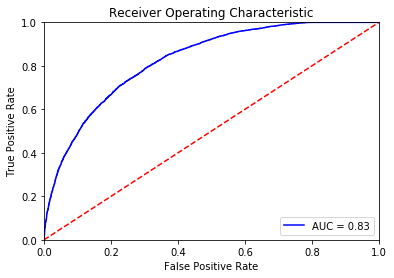

In [15]:
# calculate the fpr and tpr for all thresholds of the classification
probs = grid.best_estimator_.predict_proba(X_test)
y_pred_xgb = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, y_pred_xgb)
roc_auc = auc(fpr, tpr)

# plot ROC curve
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

In [16]:
y_pred_xgb = xgb.predict(X_test)
print(confusion_matrix(y_test, y_pred_xgb))
tn, fp, fn, tp = confusion_matrix(y_test,y_pred_xgb).ravel()
print("tn, fp, fn, tp:", tn, fp, fn, tp)
print("accuracy:", accuracy_score(y_test, y_pred_xgb))
print("f1 score:",f1_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

[[5726 1472]
 [1174 5992]]
tn, fp, fn, tp: 5726 1472 1174 5992
accuracy: 0.8157894736842105
f1 score: 0.8191387559808613
              precision    recall  f1-score   support

           0       0.83      0.80      0.81      7198
           1       0.80      0.84      0.82      7166

   micro avg       0.82      0.82      0.82     14364
   macro avg       0.82      0.82      0.82     14364
weighted avg       0.82      0.82      0.82     14364

